# Chapitre 2 — Optimisation numérique sans contraintes

### 1- Expérimentations sur la Fonction de Rosenbrock

Nous allons étudier la Fonction de Rosenbrock, un problème de test classique en optimisation. Elle est définie par :

$$f(x, y) = (1 - x)^2 + 100(y - x^2)^2$$

Cette fonction est célèbre pour sa "vallée" étroite et courbée, ce qui la rend difficile à minimiser pour de nombreux algorithmes. Le minimum global est situé en $(1, 1)$, où $f(x,y) = 0$.

In [1]:
import sympy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar 

# Configuration de l'affichage
pd.set_option('display.precision', 6)
plt.rcParams['figure.figsize'] = (10, 8)

### 1. Définition de la fonction et calcul symbolique

Nous utilisons SymPy pour définir la fonction et calculer son gradient et sa Hessienne de manière exacte.

In [2]:
# Définition des variables symboliques
x, y = sp.symbols('x y', real=True)

# Définition de la fonction f(x,y)
f_sym = (1 - x)**2 + 100 * (y - x**2)**2

# Calcul du Gradient symbolique
grad_f_sym = sp.Matrix([sp.diff(f_sym, var) for var in (x, y)])

# Calcul de la Hessienne symbolique
H_f_sym = sp.hessian(f_sym, (x, y))

print("Fonction symbolique f(x,y) :")
display(f_sym)
print("\nGradient symbolique :")
display(grad_f_sym)
print("\nMatrice Hessienne symbolique :")
display(H_f_sym)

Fonction symbolique f(x,y) :


(1 - x)**2 + 100*(-x**2 + y)**2


Gradient symbolique :


Matrix([
[-400*x*(-x**2 + y) + 2*x - 2],
[           -200*x**2 + 200*y]])


Matrice Hessienne symbolique :


Matrix([
[1200*x**2 - 400*y + 2, -400*x],
[               -400*x,    200]])

### 2. Implémentation numérique

Nous convertissons ces expressions symboliques en fonctions Python utilisables avec des vecteurs NumPy $X = [x, y]$.

In [3]:
# Fonction objectif numérique
def f_num(X):
    x, y = X[0], X[1]
    return (1 - x)**2 + 100 * (y - x**2)**2

# Gradient numérique
def grad_f_num(X):
    x, y = X[0], X[1]
    # Expressions du gradient dérivées symboliquement
    df_dx = 2*(x - 1) - 400*x*(y - x**2)
    df_dy = 200*(y - x**2)
    return np.array([df_dx, df_dy])

### 3. Algorithme de Gradient à Pas Fixe

In [4]:
def grad_pas_fixe(X0, s, eps, N_max):
    X = X0
    iterations = []
    
    for k in range(N_max):
        f_val = f_num(X)
        g = grad_f_num(X)
        norm_g = np.linalg.norm(g)
        
        iterations.append([k, X[0], X[1], f_val, norm_g, s])
        
        if norm_g < eps:
            break
            
        X_new = X - s * g
        
        if np.any(np.abs(X_new) > 1e10): 
            print(f"Arrêt de sécurité à l'itération {k} : divergence.")
            break
            
        X = X_new

    df = pd.DataFrame(iterations, columns=['k', 'x_k', 'y_k', 'f(X_k)', '||grad f(X_k)||', 's'])
    return df

#### Test de l'algorithme à pas fixe

Nous testons l'algorithme avec un point de départ arbitraire $X_0 = (0, 0)$, un pas $s=0.001$ et une tolérance $\epsilon=10^{-5}$.

In [5]:
X0 = np.array([-1.5, -0.5]) # Point de départ pour l'algorithme Rosenbrock
s_test = 0.001 
eps_test = 1e-5
N_max_test = 50000 # Nombre d'itérations augmenté pour la fonction de Rosenbrock

df_fixe = grad_pas_fixe(X0, s_test, eps_test, N_max_test)

print(f"Algorithme terminé en {len(df_fixe)} itérations.")
print("Début des itérations :")
display(df_fixe.head())
print("\nFin des itérations :")
display(df_fixe.tail())

Algorithme terminé en 25450 itérations.
Début des itérations :


,k,x_k,y_k,f(X_k),||grad f(X_k)||,s
0,0,-1.500000,-0.500000,762.500000,1743.996846,0.001
1,1,0.155000,0.050000,0.781495,6.154754,0.001
2,2,0.158300,0.044805,0.747448,4.919637,0.001
3,3,0.161234,0.040856,0.725608,3.972379,0.001
4,4,0.163870,0.037884,0.711281,3.256430,0.001



Fin des itérations :


,k,x_k,y_k,f(X_k),||grad f(X_k)||,s
25445,25445,0.999989,0.999978,1.255656e-10,0.00001,0.001
25446,25446,0.999989,0.999978,1.254654e-10,0.00001,0.001
25447,25447,0.999989,0.999978,1.253652e-10,0.00001,0.001
25448,25448,0.999989,0.999978,1.252650e-10,0.00001,0.001
25449,25449,0.999989,0.999978,1.251650e-10,0.00001,0.001


### 4. Algorithme de Gradient à Pas Optimal (Plus profonde descente)

Pour la fonction quadratique, nous avions une formule analytique pour le pas optimal $s_k = \frac{g_k^T g_k}{g_k^T M g_k}$.

Nous adaptons donc la fonction `grad_pas_optimal` pour intégrer cette recherche numérique.

In [6]:
def grad_pas_optimal(X0, eps, N_max):
    X = X0
    iterations = []
    
    for k in range(N_max):
        f_val = f_num(X)
        g = grad_f_num(X)
        norm_g = np.linalg.norm(g)
        
        if norm_g < eps:
            iterations.append([k, X[0], X[1], f_val, norm_g, 0])
            break
            
        def phi(s_candidate):
            return f_num(X - s_candidate * g)
        
        # Le bracket [0, 1] peut être trop grand pour Rosenbrock, on ajuste
        res_opt = minimize_scalar(phi, bracket=(0, 0.5), method='brent') 
        s_opt = res_opt.x
        
        iterations.append([k, X[0], X[1], f_val, norm_g, s_opt])
        
        X = X - s_opt * g

    df = pd.DataFrame(iterations, columns=['k', 'x_k', 'y_k', 'f(X_k)', '||grad f(X_k)||', 's_opt'])
    return df

#### Test de l'algorithme Rosenbrock à pas optimal

In [7]:
df_optimal = grad_pas_optimal(X0, eps_test, N_max_test)

print(f"Algorithme terminé en {len(df_optimal)} itérations.")
print("Début des itérations :")
display(df_optimal.head())
print("\nFin des itérations :")
display(df_optimal.tail())

Algorithme terminé en 12338 itérations.
Début des itérations :


,k,x_k,y_k,f(X_k),||grad f(X_k)||,s_opt
0,0,-1.500000,-0.500000,762.500000,1743.996846,0.001130
1,1,0.370007,0.121453,0.420770,3.256757,0.003577
2,2,0.366334,0.132507,0.401820,1.073984,0.026714
3,3,0.393560,0.141555,0.385551,2.810298,0.003488
4,4,0.390468,0.150857,0.371788,1.019922,0.022666



Fin des itérations :


,k,x_k,y_k,f(X_k),||grad f(X_k)||,s_opt
12333,12333,0.999992,0.999984,6.520570e-11,0.00001,0.002068
12334,12334,0.999992,0.999984,6.510166e-11,0.00001,0.001929
12335,12335,0.999992,0.999984,6.499779e-11,0.00001,0.002068
12336,12336,0.999992,0.999984,6.489408e-11,0.00001,0.001929
12337,12337,0.999992,0.999984,6.479053e-11,0.00001,0.000000


### 5. Visualisation des trajectoires

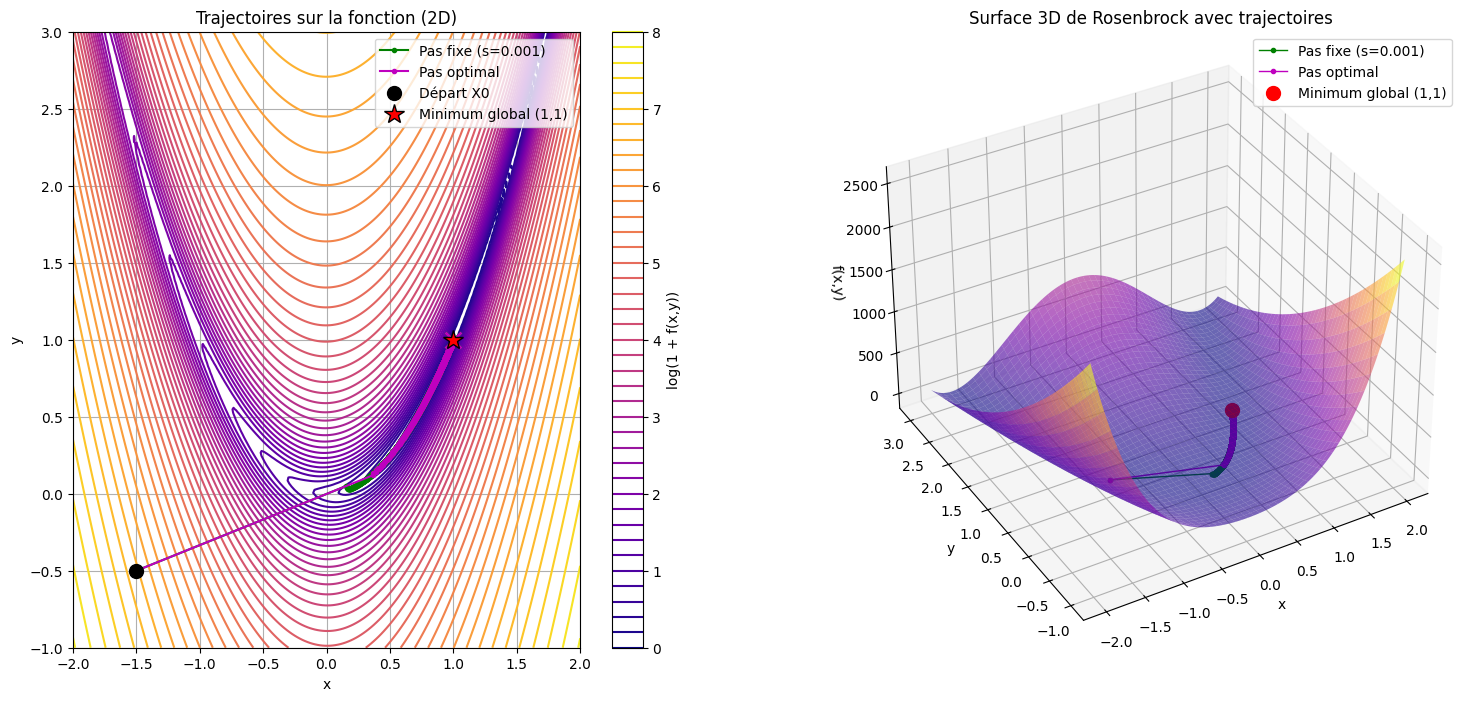

In [12]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

# Grille
x_grid = np.linspace(-2, 2, 200)
y_grid = np.linspace(-1, 3, 200)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid)
Z_grid = f_num([X_grid, Y_grid])

fig = plt.figure(figsize=(18,8))

# ---- 1. Contour 2D ----
ax1 = fig.add_subplot(1, 2, 1)
Z_log = np.log1p(Z_grid)
contour = ax1.contour(X_grid, Y_grid, Z_log, levels=40, cmap='plasma')
plt.colorbar(contour, ax=ax1, label='log(1 + f(x,y))')

# Trajectoires
ax1.plot(df_fixe['x_k'], df_fixe['y_k'], 'g.-', label=f'Pas fixe (s={s_test})')
ax1.plot(df_optimal['x_k'], df_optimal['y_k'], 'm.-', label='Pas optimal')
# Points de départ et d'arrivée
ax1.plot(X0[0], X0[1], 'ko', markersize=10, label='Départ X0')
ax1.plot(df_fixe.iloc[-1]['x_k'], df_fixe.iloc[-1]['y_k'], 'gx', markersize=12, markeredgewidth=2)
ax1.plot(df_optimal.iloc[-1]['x_k'], df_optimal.iloc[-1]['y_k'], 'mx', markersize=12, markeredgewidth=2)
# Minimum global
ax1.plot(1, 1, 'r*', markersize=15, markeredgecolor='black', label='Minimum global (1,1)')

ax1.set_title("Trajectoires sur la fonction (2D)")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.legend()
ax1.grid(True)

# ---- 2. Surface 3D ----
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(X_grid, Y_grid, Z_grid, cmap='plasma', alpha=0.6)  # transparent
# Trajectoires en 3D
ax2.plot(df_fixe['x_k'], df_fixe['y_k'], df_fixe['f(X_k)'], 'g.-', label=f'Pas fixe (s={s_test})', linewidth=1)
ax2.plot(df_optimal['x_k'], df_optimal['y_k'], df_optimal['f(X_k)'], 'm.-', label='Pas optimal', linewidth=1)
# Minimum global
ax2.scatter(1, 1, f_num([1,1]), color='red', s=100, label='Minimum global (1,1)')

# Labels et rotation pour mieux voir
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('f(x,y)')
ax2.view_init(elev=35, azim=-120)  # angle de vue ajusté
ax2.set_title("Surface 3D de Rosenbrock avec trajectoires")
ax2.legend()

plt.show()


Le graphique et les tableaux d'itérations nous fournissent les éléments pour analyser le comportement des algorithmes sur la fonction de Rosenbrock.